In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from os import listdir, makedirs
import pickle

In [2]:
# Data location
PROJECT_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp-2'
DATA_PATH = f'{PROJECT_PATH}/data'
RESULTS_PATH = f'{PROJECT_PATH}/results'
TRANSITION_RESULTS_DIR = 'transition-influence/training'
FIG_PATH = f'{PROJECT_PATH}/figs'

# Model info
MODELS = [d for d in listdir(DATA_PATH) if d[0] != '.']

TRANSITION_INFLUENCE_COLORS = {
    'incidental': '#F52342',
    'true': '#FFBC42'
}

In [3]:
# Mkae figure path if it does not exist
makedirs(FIG_PATH, exist_ok=True)

# Functions

## Helper Functions

In [4]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def information_from_label(model_label):
    """
    Get field information from model label

    Arguments
    ---------
    model_label : str
        model label
    
    Returns
    -------
    fields
    """
    fields = {}
    for field in model_label.split('_'):
        if not '-' in field:
            continue
        key, value = field.split('-')
        fields[key] = value
    return fields

def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            np.abs(round(x.left, n)),
            np.abs(round(x.right, n))
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned

## Plot Functions

In [5]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            ci = None
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    elif y == 'resid':
        ax.axhline(.72, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Residual')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        max_reward = np.max(df['reward'])
        chance = max_reward/2
    elif y == 'p':
        chance = .25
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.set_ylim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)

# Load Data

## Training

In [6]:
# Load training data
training_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/training')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    training_df.append(model_df)
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)
training_df['block'] = 1
training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,composition,successor,p,reward,correct,model,edim,depth,freq,block
0,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,[3 3 0 0],[4 4 0 0],0.250000,0,0,ff,4,1,uniform,1
1,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,[0 2 0 2],[0 1 0 1],0.397423,0,0,ff,4,1,uniform,1
2,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,[2 0 0 2],[1 0 0 1],0.223394,0,0,ff,4,1,uniform,1
3,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,[3 0 0 3],[4 0 0 4],0.316110,2,1,ff,4,1,uniform,1
4,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,[0 3 0 2],[0 4 0 1],0.382134,1,0,ff,4,1,uniform,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4799995,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,[5 4],[8 1],0.948837,2,1,ff,2,3,nonuniform,1
4799996,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,[4 5],[1 8],0.977123,2,1,ff,2,3,nonuniform,1
4799997,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,[5 4],[8 1],0.968985,2,1,ff,2,3,nonuniform,1
4799998,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,[4 4],[1 1],0.243287,0,0,ff,2,3,nonuniform,1


## Test

In [7]:
test_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/test')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    test_df.append(model_df)
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,options,composition,successor,p,reward,correct,model,edim,depth,freq
0,150,model-ff_edim-4_depth-1_freq-uniform,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.766656,0,0,ff,4,1,uniform
1,150,model-ff_edim-4_depth-1_freq-uniform,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.445031,0,0,ff,4,1,uniform
2,150,model-ff_edim-4_depth-1_freq-uniform,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.998264,0,0,ff,4,1,uniform
3,150,model-ff_edim-4_depth-1_freq-uniform,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.998955,0,0,ff,4,1,uniform
4,150,model-ff_edim-4_depth-1_freq-uniform,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.146043,1,0,ff,4,1,uniform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367995,175,model-ff_edim-2_depth-3_freq-nonuniform,0.664033,0,13.996385,13.996385,1,0,1.800429,False,...,[[[4 0]\n [5 0]]\n\n [[0 4]\n [0 5]]],[5 4],[8 1],1.000000,1,0,ff,2,3,nonuniform
367996,149,model-ff_edim-2_depth-3_freq-nonuniform,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,[[[4 0]\n [5 0]]\n\n [[0 4]\n [0 5]]],[4 5],[1 8],0.997406,1,0,ff,2,3,nonuniform
367997,149,model-ff_edim-2_depth-3_freq-nonuniform,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,[[[4 0]\n [5 0]]\n\n [[0 4]\n [0 5]]],[4 5],[1 8],1.000000,2,1,ff,2,3,nonuniform
367998,149,model-ff_edim-2_depth-3_freq-nonuniform,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,[[[4 0]\n [5 0]]\n\n [[0 4]\n [0 5]]],[5 4],[8 1],1.000000,2,1,ff,2,3,nonuniform


## Representations

In [8]:
representations = {}
for model in MODELS:
    model_info = information_from_label(model)
    for fname in listdir(f'{DATA_PATH}/{model}/representations'):
        if fname.startswith('.'):
            continue
        agent_id = int(fname.split('_')[1].replace('.pkl', ''))
        with open(f'{DATA_PATH}/{model}/representations/{fname}', 'rb') as f:
            representations[model, agent_id] = standardize_reps_order(
                pickle.load(f)
            )
            for key, value in model_info.items():
                representations[model, agent_id][key] = value

## Subject Information 

In [9]:
subj_df = test_df[[
    'id',
    'model_label',
    'freq',
    'depth',
    'alpha',
    'beta',
    'gamma'
]]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df

,id,model_label,freq,depth,alpha,beta,gamma
0,150,model-ff_edim-4_depth-1_freq-uniform,uniform,1,0.746698,0.086250,1
1,144,model-ff_edim-4_depth-1_freq-uniform,uniform,1,0.108021,19.645513,1
2,178,model-ff_edim-4_depth-1_freq-uniform,uniform,1,0.625936,1.260263,1
3,193,model-ff_edim-4_depth-1_freq-uniform,uniform,1,0.042470,191.490773,1
4,187,model-ff_edim-4_depth-1_freq-uniform,uniform,1,0.351090,0.173653,1
...,...,...,...,...,...,...,...
5995,203,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,3,0.484746,1.032704,1
5996,12,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,3,0.120530,3.089785,1
5997,161,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,3,0.645778,8.389189,1
5998,175,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,3,0.664033,13.996385,1


## Transition Influence

### Results

In [12]:
trans_influence_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/agent'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        agent_id = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'id': agent_id,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_df.append(coefs_df)

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['model_label', 'id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information
trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = ['model_label', 'id']
)

trans_influence_df

,model_label,id,action,transition,coef,edim,sdim,depth,alpha,beta,gamma,gamma_binned
0,model-ff_edim-3_sdim-2_depth-1,228,1,incidental,2.021,3,2,1,0.457787,1.489463,1,"(1.0, 1.0]"
1,model-ff_edim-3_sdim-2_depth-1,228,2,incidental,0.694,3,2,1,0.457787,1.489463,1,"(1.0, 1.0]"
2,model-ff_edim-3_sdim-2_depth-1,228,3,incidental,1.834,3,2,1,0.457787,1.489463,1,"(1.0, 1.0]"
3,model-ff_edim-3_sdim-2_depth-1,214,1,incidental,1.818,3,2,1,0.841680,0.028978,1,"(1.0, 1.0]"
4,model-ff_edim-3_sdim-2_depth-1,214,2,incidental,1.103,3,2,1,0.841680,0.028978,1,"(1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
17777,model-ff_edim-2_sdim-2_depth-2,225,2,true,2.444,2,2,2,0.849889,0.508034,1,"(1.0, 1.0]"
17778,model-ff_edim-2_sdim-2_depth-2,225,3,true,2.300,2,2,2,0.849889,0.508034,1,"(1.0, 1.0]"
17779,model-ff_edim-2_sdim-2_depth-2,231,1,true,7.950,2,2,2,0.765247,14.825493,1,"(1.0, 1.0]"
17780,model-ff_edim-2_sdim-2_depth-2,231,2,true,4.696,2,2,2,0.765247,14.825493,1,"(1.0, 1.0]"


In [13]:
trans_influence_trial_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/trial'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        trial = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'trial': trial,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_trial_df.append(coefs_df)

trans_influence_trial_df = pd.concat(trans_influence_trial_df)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Convert to long
trans_influence_trial_df = pd.melt(
    trans_influence_trial_df,
    id_vars = ['model_label', 'trial', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Add parameter information
trans_influence_trial_df = pd.merge(
    trans_influence_trial_df,
    subj_df[['model_label', 'sdim', 'edim', 'depth']].drop_duplicates(),
    on = ['model_label']
)

trans_influence_trial_df

,model_label,trial,action,transition,coef,sdim,edim,depth
0,model-ff_edim-3_sdim-2_depth-1,214,1,incidental,1.102,2,3,1
1,model-ff_edim-3_sdim-2_depth-1,214,2,incidental,1.943,2,3,1
2,model-ff_edim-3_sdim-2_depth-1,214,3,incidental,2.291,2,3,1
3,model-ff_edim-3_sdim-2_depth-1,374,1,incidental,2.156,2,3,1
4,model-ff_edim-3_sdim-2_depth-1,374,2,incidental,0.819,2,3,1
...,...,...,...,...,...,...,...,...
6691,model-ff_edim-2_sdim-2_depth-2,68,2,true,2.746,2,2,2
6692,model-ff_edim-2_sdim-2_depth-2,68,3,true,2.243,2,2,2
6693,model-ff_edim-2_sdim-2_depth-2,40,1,true,2.180,2,2,2
6694,model-ff_edim-2_sdim-2_depth-2,40,2,true,1.183,2,2,2


### Plot successor representations learned for agent = 1

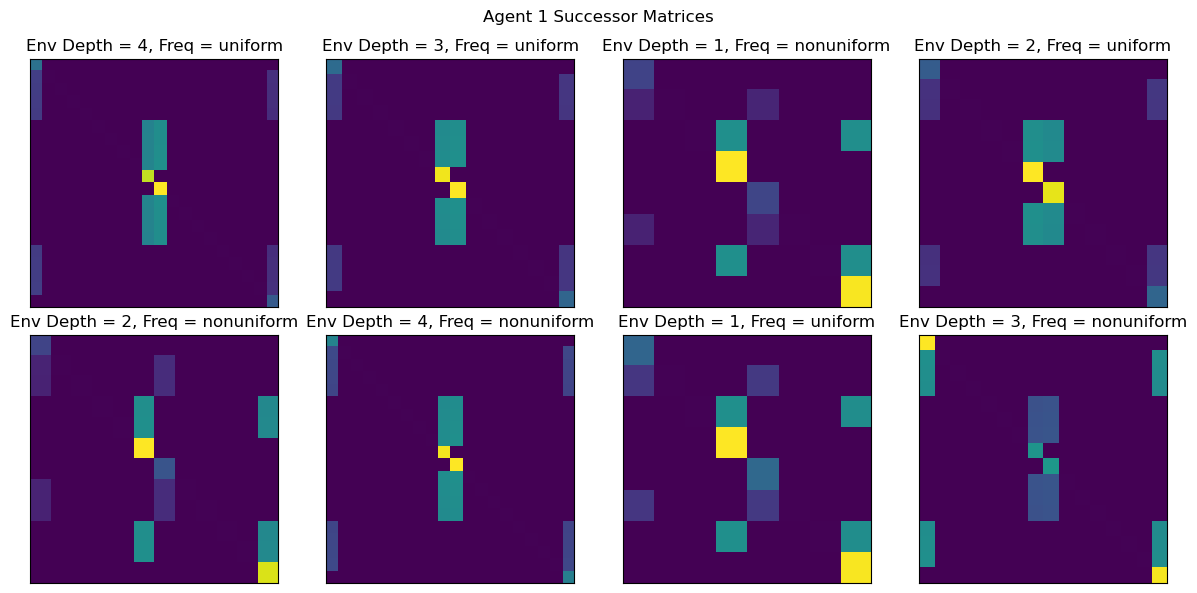

In [91]:
env_dim = 2
agent_id = 1

edim_models = [
    model_label for model_label in MODELS
    if f'edim-{env_dim}' in model_label

]
n_subplots = len(edim_models)
n_rows = 2
n_cols = int(np.ceil(n_subplots/n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, model in enumerate(edim_models):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(representations[model, agent_id]['M'])
    depth = representations[model, agent_id]['depth']
    freq = representations[model, agent_id]['freq']
    ax.set_title(f'Env Depth = {depth}, Freq = {freq}')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'Agent {agent_id} Successor Matrices')
fig.tight_layout()

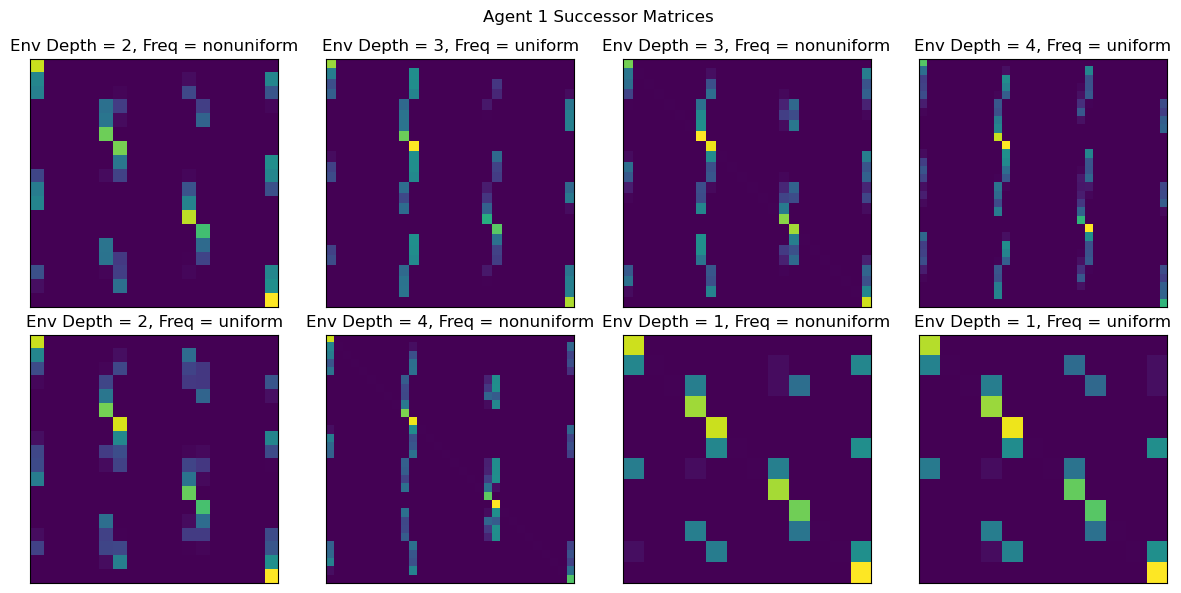

In [92]:
env_dim = 3
agent_id = 1

edim_models = [
    model_label for model_label in MODELS
    if f'edim-{env_dim}' in model_label

]
n_subplots = len(edim_models)
n_rows = 2
n_cols = int(np.ceil(n_subplots/n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, model in enumerate(edim_models):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(representations[model, agent_id]['M'])
    depth = representations[model, agent_id]['depth']
    freq = representations[model, agent_id]['freq']
    ax.set_title(f'Env Depth = {depth}, Freq = {freq}')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'Agent {agent_id} Successor Matrices')
fig.tight_layout()

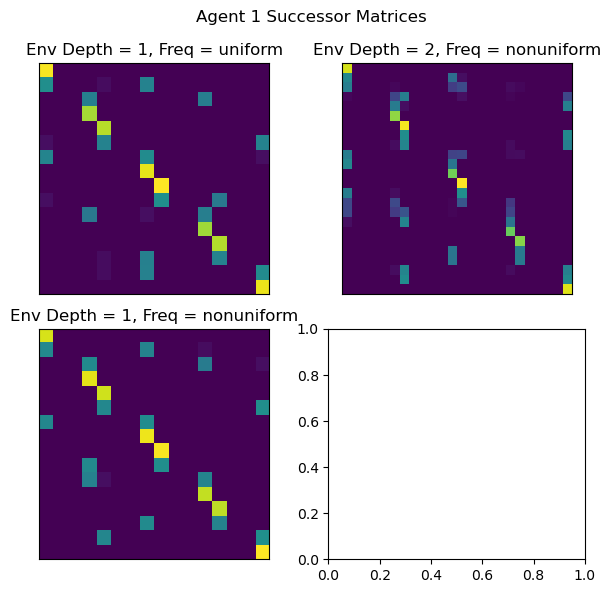

In [93]:
env_dim = 4
agent_id = 1

edim_models = [
    model_label for model_label in MODELS
    if f'edim-{env_dim}' in model_label

]
n_subplots = len(edim_models)
n_rows = 2
n_cols = int(np.ceil(n_subplots/n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, model in enumerate(edim_models):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(representations[model, agent_id]['M'])
    depth = representations[model, agent_id]['depth']
    freq = representations[model, agent_id]['freq']
    ax.set_title(f'Env Depth = {depth}, Freq = {freq}')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'Agent {agent_id} Successor Matrices')
fig.tight_layout()

## Plot weight of incidental versus true information in successor matrices

### Get incidental vs true information weight

In [10]:
def get_M_masks(key, representations):
     feats = []
     for lab in representations[key]['row_labels']:
          if len(lab) == (int(representations[key]['edim']) + 1):
              lab = lab.replace('10', 'a')
          feats.append([i != '0' for i in lab])
     feats = np.array(feats)
     true_mask = feats@feats.T
     incidental_mask = np.logical_not(true_mask)
     np.fill_diagonal(true_mask, False)
     return true_mask, incidental_mask

In [11]:
# Get incidental weights for each model and agent
incidental_weights = []
n_agents = int(len(representations)/len(MODELS))
for model in MODELS:
    for i in range(1, n_agents + 1):

        try:

            # Get within- (true) and between-feature (incidental) masks
            true_mask, incidental_mask = get_M_masks((model, i), representations)

            # Sum information in true vs incidental regions of M
            M = representations[model, i]['M']
            true_sum = np.sum(M[true_mask])
            incidental_sum = np.sum(M[incidental_mask])
            true_max = np.max(M[true_mask])
            incidental_max = np.max(M[incidental_mask])

            # Get ratio of incidental to true information
            incidental_weight = incidental_sum/(true_sum + incidental_sum)
            incidental_max_weight = incidental_max/(true_max + incidental_max)

            # Add to DataFrame
            incidental_weights.append({
                'id': i,
                'model_label': model,
                'freq': representations[model, i]['freq'],
                'edim': int(representations[model, i]['edim']),
                'depth': int(representations[model, i]['depth']),
                'incidental_weight': incidental_weight,
                'incidental_max_weight': incidental_max_weight
            })

        except:
            continue

# Convert to data frame
incidental_weights_df = pd.DataFrame(incidental_weights)

incidental_weights_df

,id,model_label,freq,edim,depth,incidental_weight,incidental_max_weight
0,1,model-ff_edim-4_depth-1_freq-uniform,uniform,4,1,0.500371,0.475629
1,2,model-ff_edim-4_depth-1_freq-uniform,uniform,4,1,0.499830,0.270980
2,3,model-ff_edim-4_depth-1_freq-uniform,uniform,4,1,0.501011,0.449676
3,4,model-ff_edim-4_depth-1_freq-uniform,uniform,4,1,0.501806,0.486295
4,5,model-ff_edim-4_depth-1_freq-uniform,uniform,4,1,0.501007,0.328583
...,...,...,...,...,...,...,...
5995,246,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,2,3,0.496763,0.462801
5996,247,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,2,3,0.500000,0.500000
5997,248,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,2,3,0.500000,0.500000
5998,249,model-ff_edim-2_depth-3_freq-nonuniform,nonuniform,2,3,0.499798,0.390432


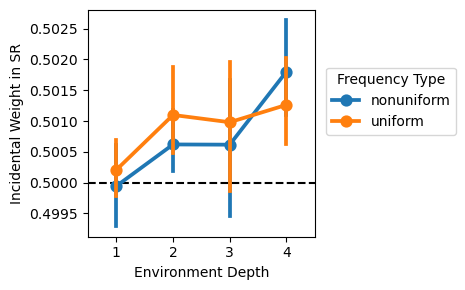

In [12]:
idx = incidental_weights_df['edim'] == 2
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'freq',
    ax = ax
)
ax.legend(title='Frequency Type', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

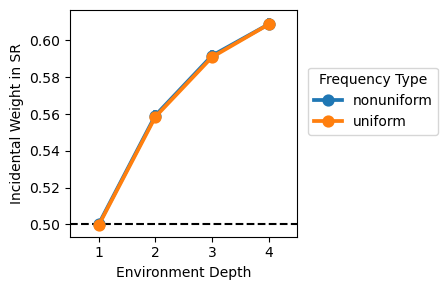

In [13]:
idx = incidental_weights_df['edim'] == 3
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'freq',
    ax = ax
)
ax.legend(title='Frequency Type', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

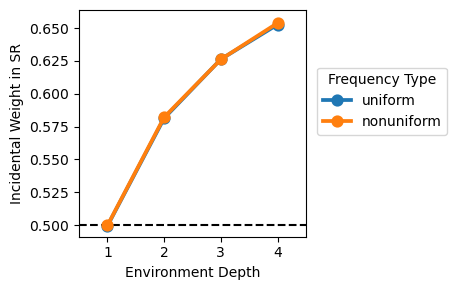

In [14]:
idx = incidental_weights_df['edim'] == 4
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'freq',
    ax = ax
)
ax.legend(title='Frequency Type', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

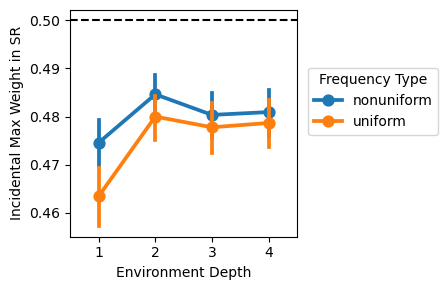

In [15]:
idx = incidental_weights_df['edim'] == 2
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'freq',
    ax = ax
)
ax.legend(title='Frequency Type', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Max Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

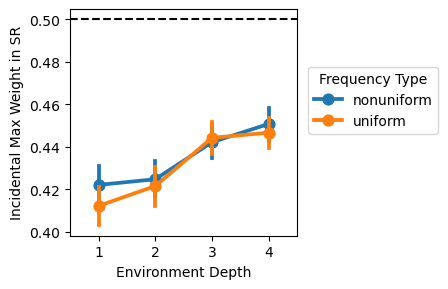

In [16]:
idx = incidental_weights_df['edim'] == 3
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'freq',
    ax = ax
)
ax.legend(title='Frequency Type', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Max Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

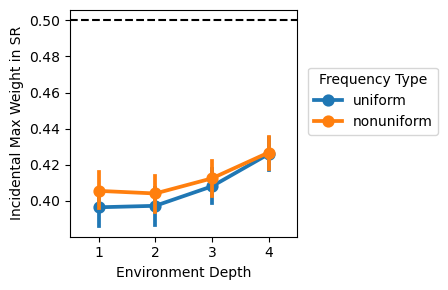

In [17]:
idx = incidental_weights_df['edim'] == 4
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'freq',
    ax = ax
)
ax.legend(title='Frequency Type', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Max Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

# Training Analysis

In [18]:


def get_target_frequency(df):

    # Get rates of each target per model and id
    target_counts = df.groupby(
        ['id', 'model_label', 'target']
        ).size().reset_index(name='count')
    total_counts = target_counts.groupby(
        ['id', 'model_label']
        )['count'].transform('sum')
    target_counts['rate'] = target_counts['count']/total_counts

    # Find the highest and lowest rates per id and model
    highest_rate = target_counts.groupby(
        ['id', 'model_label']
        )['rate'].transform('max')

    # Categorize each item
    target_counts['freq_target'] = target_counts['rate'] == highest_rate
    target_counts['freq_target'] = target_counts['freq_target'].astype(int)
    df = pd.merge(
        df,
        target_counts,
    )

    return df

In [19]:
training_df = get_target_frequency(training_df)
training_df


,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,reward,correct,model,edim,depth,freq,block,count,rate,freq_target
0,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,0,0,ff,4,1,uniform,1,60,0.041667,1
1,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,0,0,ff,4,1,uniform,1,60,0.041667,1
2,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,0,0,ff,4,1,uniform,1,60,0.041667,1
3,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,2,1,ff,4,1,uniform,1,60,0.041667,1
4,161,model-ff_edim-4_depth-1_freq-uniform,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,1,0,ff,4,1,uniform,1,60,0.041667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4799995,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,2,1,ff,2,3,nonuniform,1,80,0.333333,1
4799996,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,2,1,ff,2,3,nonuniform,1,80,0.333333,1
4799997,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,2,1,ff,2,3,nonuniform,1,80,0.333333,1
4799998,187,model-ff_edim-2_depth-3_freq-nonuniform,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,0,0,ff,2,3,nonuniform,1,40,0.166667,0


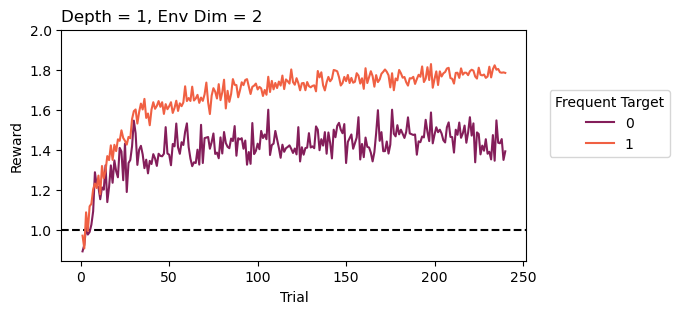

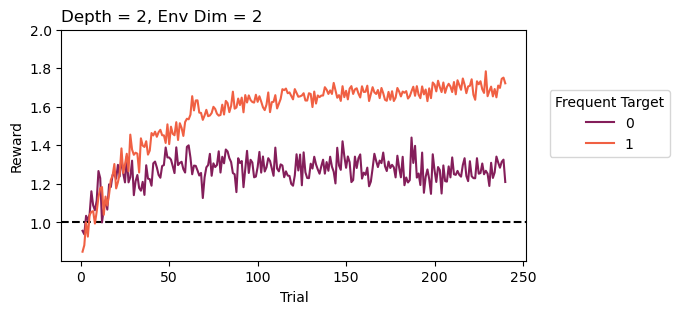

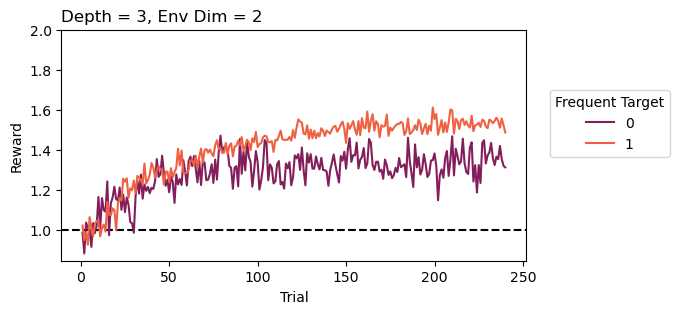

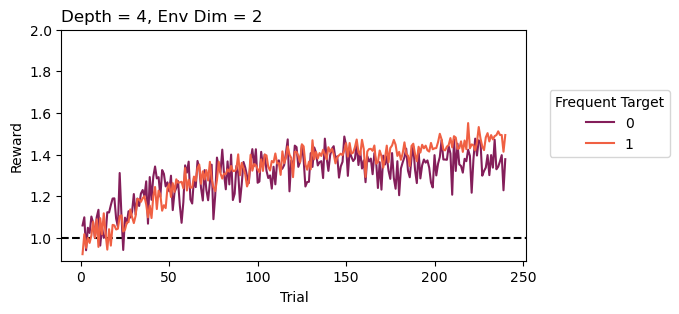

In [20]:
idx = (
    (training_df['depth'] == '1') &
    (training_df['edim'] == '2') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 1, Env Dim = 2',
)

idx = (
    (training_df['depth'] == '2') &
    (training_df['edim'] == '2') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 2, Env Dim = 2',
)

idx = (
    (training_df['depth'] == '3') &
    (training_df['edim'] == '2') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 3, Env Dim = 2',
)

idx = (
    (training_df['depth'] == '4') &
    (training_df['edim'] == '2') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 4, Env Dim = 2',
)


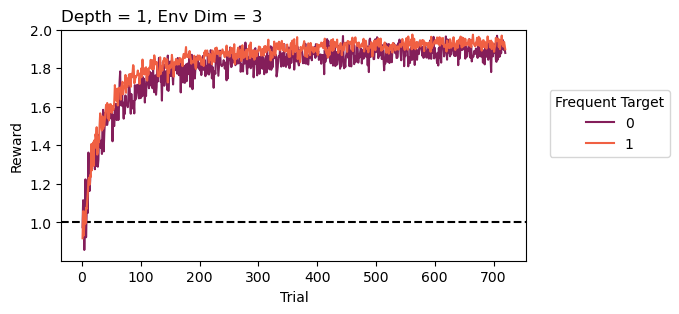

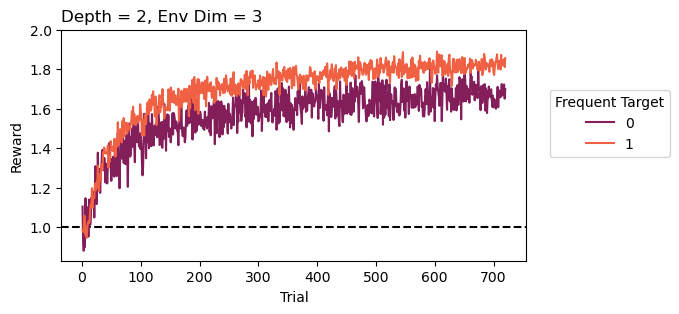

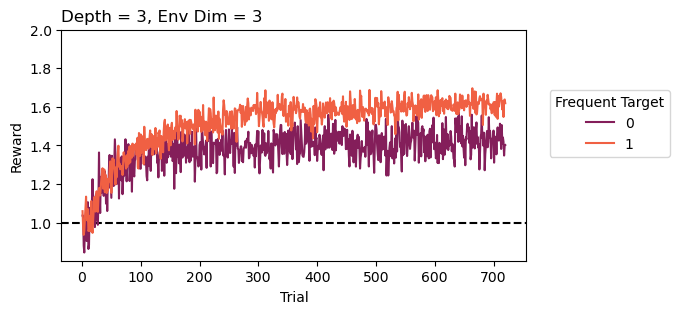

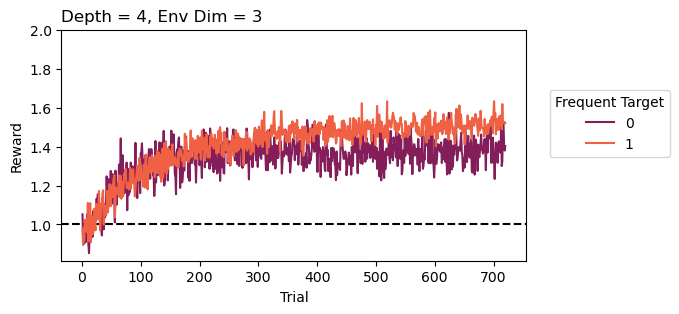

In [21]:
idx = (
    (training_df['depth'] == '1') &
    (training_df['edim'] == '3') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 1, Env Dim = 3',
)

idx = (
    (training_df['depth'] == '2') &
    (training_df['edim'] == '3') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 2, Env Dim = 3',
)

idx = (
    (training_df['depth'] == '3') &
    (training_df['edim'] == '3') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 3, Env Dim = 3',
)

idx = (
    (training_df['depth'] == '4') &
    (training_df['edim'] == '3') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 4, Env Dim = 3',
)


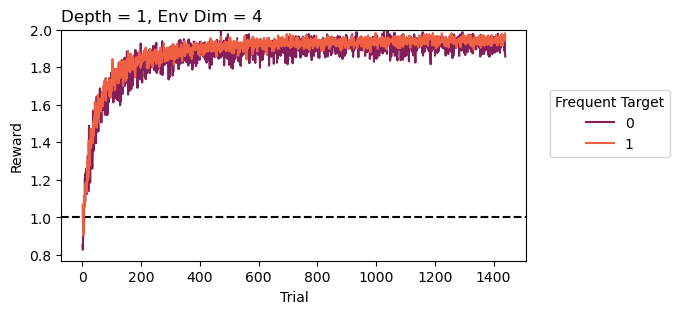

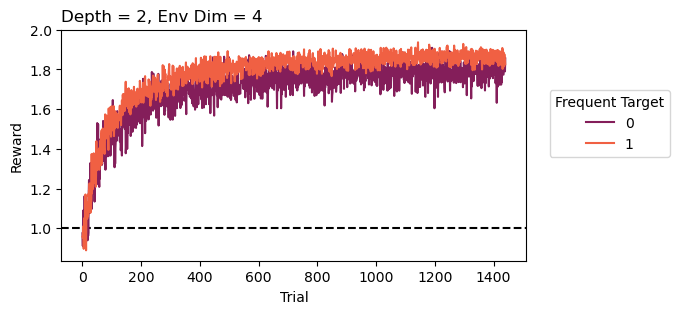

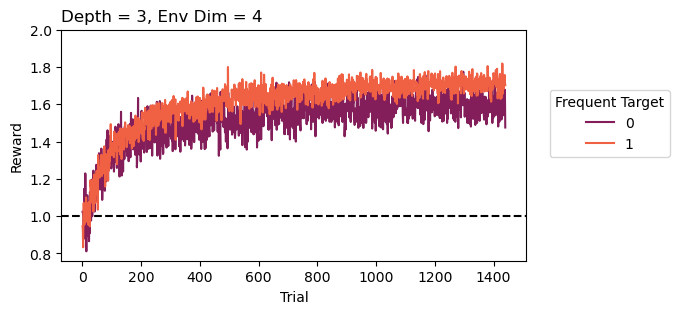

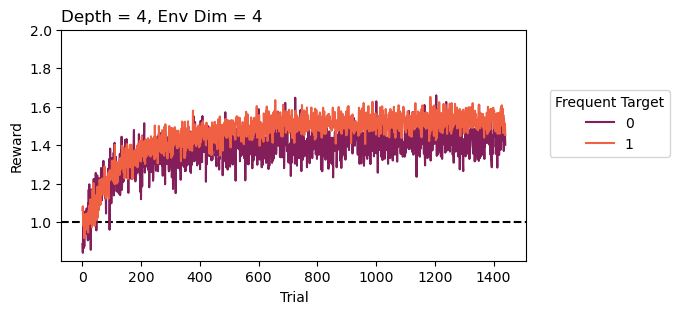

In [22]:
idx = (
    (training_df['depth'] == '1') &
    (training_df['edim'] == '4') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 1, Env Dim = 4',
)

idx = (
    (training_df['depth'] == '2') &
    (training_df['edim'] == '4') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 2, Env Dim = 4',
)

idx = (
    (training_df['depth'] == '3') &
    (training_df['edim'] == '4') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 3, Env Dim = 4',
)

idx = (
    (training_df['depth'] == '4') &
    (training_df['edim'] == '4') &
    (training_df['freq'] == 'nonuniform')
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'freq_target',
    legend_title = 'Frequent Target',
    title = 'Depth = 4, Env Dim = 4',
)


In [23]:
# Add training target information
test_df = pd.merge(
    test_df,
    training_df[['id', 'model_label', 'target', 'freq_target']],
)


In [24]:
test_df['old'] = test_df['target_comb'] == test_df['options_comb']
test_df['old'] = test_df['old'].astype(int)


In [25]:
test_summary = test_df[[
    'id',
    'model_label',
    'freq',
    'depth',
    'edim',
    'old',
    'freq_target',
    'reward'
]]
test_summary = test_summary.groupby([
    'id',
    'model_label',
    'freq',
    'depth',
    'edim',
    'old',
    'freq_target'
]).mean().reset_index()
test_summary


,id,model_label,freq,depth,edim,old,freq_target,reward
0,1,model-ff_edim-2_depth-1_freq-nonuniform,nonuniform,1,2,1,0,2.000000
1,1,model-ff_edim-2_depth-1_freq-nonuniform,nonuniform,1,2,1,1,1.000000
2,1,model-ff_edim-2_depth-1_freq-uniform,uniform,1,2,1,1,1.500000
3,1,model-ff_edim-2_depth-2_freq-nonuniform,nonuniform,2,2,1,0,2.000000
4,1,model-ff_edim-2_depth-2_freq-nonuniform,nonuniform,2,2,1,1,1.000000
...,...,...,...,...,...,...,...,...
14995,250,model-ff_edim-4_depth-4_freq-nonuniform,nonuniform,4,4,0,1,0.600000
14996,250,model-ff_edim-4_depth-4_freq-nonuniform,nonuniform,4,4,1,0,1.333333
14997,250,model-ff_edim-4_depth-4_freq-nonuniform,nonuniform,4,4,1,1,1.500000
14998,250,model-ff_edim-4_depth-4_freq-uniform,uniform,4,4,0,1,0.550000


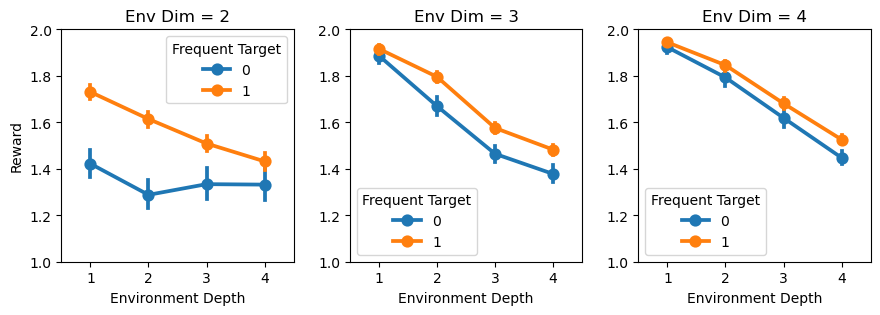

In [26]:

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

for i, edim in enumerate(['2', '3', '4']):
    ax = axs[i]
    idx = (
        (test_summary['edim'] == edim) &
        (test_summary['old'] == 1)
    )
    sns.pointplot(
        data = test_summary.loc[idx],
        x = 'depth',
        y = 'reward',
        hue = 'freq_target',
        ax = ax
    )
    ax.set_title(f'Env Dim = {edim}')
    ax.set_xlabel('Environment Depth')
    ax.legend(title='Frequent Target')
    ax.set_ylim(1, 2)
    if i == 0:
        ax.set_ylabel('Reward')
    else:
        ax.set_ylabel('')
    set_axis_ratio(ax)
fig.tight_layout()

### Transition Influence

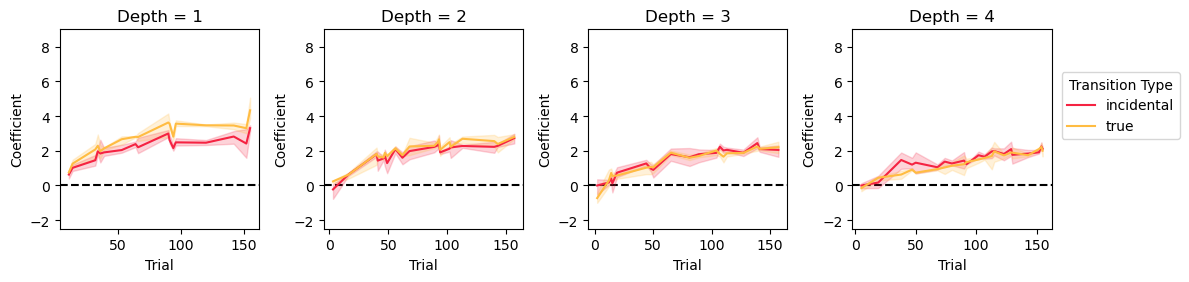

In [87]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['edim'] == '2')
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

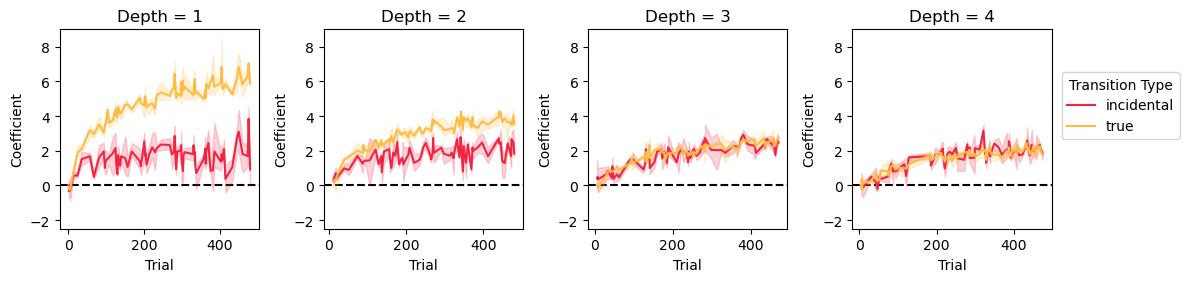

In [86]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['edim'] == '3')
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

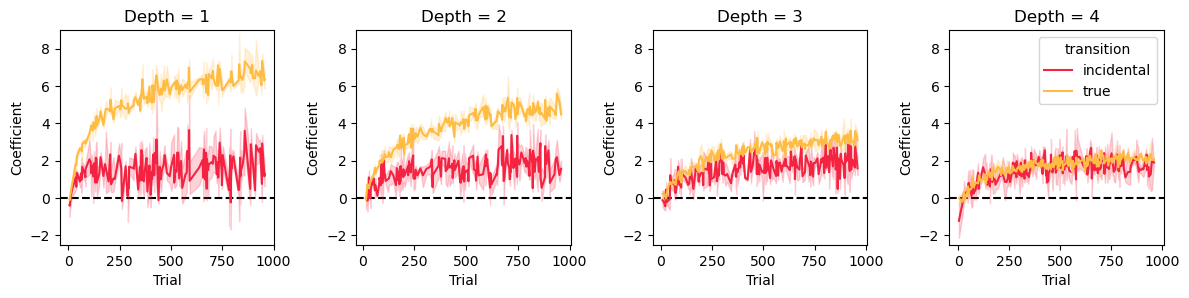

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['edim'] == '4')
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

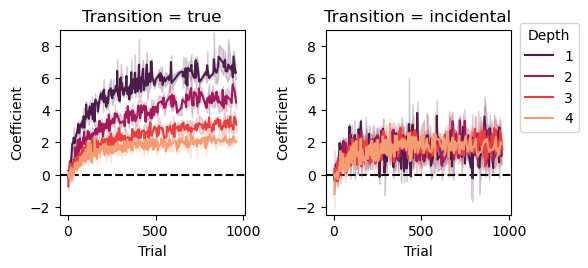

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
for i, transition in enumerate(['true', 'incidental']):
    ax = axs[i]
    idx = trans_influence_trial_df['transition'] == transition
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'depth',
        palette = 'rocket',
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Transition = {transition}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 1:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Depth', loc=(1.05, .45))
fig.tight_layout()

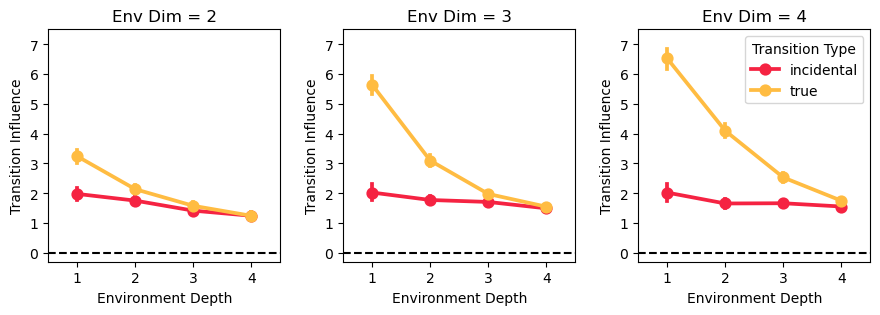

In [26]:
plot_df = trans_influence_df[['id', 'edim', 'depth', 'transition', 'coef']]
plot_df = plot_df.groupby(['id', 'edim', 'depth', 'transition'])
plot_df = plot_df.mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, edim in enumerate(['2', '3', '4']):
    ax = axs[i]
    idx = plot_df['edim'] == edim
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.pointplot(
        data = plot_df.loc[idx],
        x = 'depth',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-.3, 7.5)
    ax.set_title(f'Env Dim = {edim}')
    ax.set_xlabel('Environment Depth')
    ax.set_ylabel('Transition Influence')
    if i < 2:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type')
fig.tight_layout()